## Import modules

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from operator import itemgetter
pd.set_option('display.max_colwidth', 800)

## Import Data

In [2]:
path = r'/mnt/datastore/data/antivax/timelines' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

tweets = pd.concat(li, axis=0, ignore_index=True)
tweets = tweets[~tweets['created_at'].isna()]
tweets.head(3)

,tweet_id,user_id,user_name,followers,friends,user_location,likes,retweets,text,created_at,urls,in_reply_to_user_id,in_reply_to_screen_name,user_mentions,retweeted_status
0,1064867712890019841,1328937145,Predatoutheures,53.0,272,NaN,0,0.0,@immoboum ET SI... L'on s'occupait des Banques Françaises dans le cadre des évasions fiscales juste pour retrouver l'équité entre le Vulgum Pecus et la Justice de la République comme ça juste pour voir...!!! A BON ENTENDEUR https://t.co/zcuY5nDjKE,Tue Nov 20 13:07:01 +0000 2018,[],NaN,NaN,[],NaN
1,1064866076511617026,1328937145,Predatoutheures,53.0,272,NaN,0,0.0,@20Minutes Ce n'est pas les ATTENTATS que le Gouvernement doit craindre c'est la COLERE des Français et lorsque les Français sont en colère LA VEUVE PLEURE A NOUVEAU DU SANG...A BON ENTENDEUR...AH au fait je suis toujours à la même adresse les Zonzons et autres mais vous savez cela Non..! https://t.co/jSsyIqf1OE,Tue Nov 20 13:00:31 +0000 2018,[],2649991.0,20Minutes,"[User(ID=2649991, ScreenName=20Minutes)]",NaN
2,1064864589119176705,1328937145,Predatoutheures,53.0,272,NaN,0,0.0,"@lacavapeter VOILA CA C'est la France... Liberté- Egalité-Fraternité le Pays des Droits de l'homme, et Homme est au Singulier cela veut tout dire ...!!! A BON ENTENDEUR https://t.co/1kVRBlCW7S",Tue Nov 20 12:54:36 +0000 2018,[],934762328.0,lacavapeter,"[User(ID=934762328, ScreenName=lacavapeter)]",NaN


## Clean Data

In [3]:
# Parse user mentions
tweets['user_mentions_id'] = tweets["user_mentions"].str.find("ID=([0-9]+),")
tweets['user_mentions_screen_name'] = tweets["user_mentions"].str.find("ScreenName=(\w+)\)")


In [4]:
# Parse retweets infos
tweets["retweeted_screen_name"] = tweets[~tweets["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['screen_name'])
tweets["retweeted_id"] = tweets[~tweets["retweeted_status"].isna()].retweeted_status.apply(lambda x: json.loads(x)['user']['id_str'])

In [5]:
# Convert Ids to numeric
tweets["in_reply_to_user_id"] = pd.to_numeric(tweets["in_reply_to_user_id"], errors='coerce')
tweets["retweeted_id"] = pd.to_numeric(tweets["retweeted_id"], errors='coerce')
tweets["user_mentions_id"] = pd.to_numeric(tweets["user_mentions_id"], errors='coerce')
tweets["user_id"] = pd.to_numeric(tweets["user_id"], errors='coerce')

In [6]:
# Get the interactions between the different users
def get_interactions(row):
    user = row["user_id"], row["user_name"]
    
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
        
    interactions.discard((row["user_id"], row["user_name"]))
    interactions.discard((None, None))
    return user, interactions

In [7]:
TOP_USERS = 400
all_users = np.append(tweets.user_name,tweets.in_reply_to_screen_name)
all_users = np.append(all_users, tweets.retweeted_screen_name)
all_users = np.append(all_users, tweets.user_mentions_screen_name)
all_users = pd.DataFrame(all_users)
important_users = all_users[0].value_counts()[1:TOP_USERS]
important_users = list(important_users.keys())

In [9]:
seed_users = np.unique(tweets.user_name.values).tolist()
filter_users = list(set(seed_users) | set(important_users)) 
len(filter_users)

415

In [10]:
tweets_filtered = tweets[tweets.in_reply_to_screen_name.isin(filter_users) 
       | tweets.retweeted_screen_name.isin(filter_users)
       | tweets.user_mentions_screen_name.isin(filter_users)]
tweets_filtered = tweets_filtered.reset_index()
tweets_filtered = tweets_filtered.where((pd.notnull(tweets_filtered)), None)
tweets_filtered.shape[0]

73297

## Build the graph

In [11]:
graph = nx.Graph()
#graph.add_nodes_from(filter_users)
for index, tweet in tweets_filtered.iterrows():
    print("{}/{}\r".format(index, tweets_filtered.shape[0]), end="")
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    #tweet_id = tweet["tweet_id"]
    for interaction in interactions:
        int_id, int_name = interaction
        if(user_name in filter_users and int_name in filter_users):
            # Add or update node user
            if graph.has_node(user_name):
                graph.nodes[user_name]['weight'] += 1
            else:
                graph.add_node(user_name, weight=1)
            
            # Add or update node interaction
            if graph.has_node(int_name):
                graph.nodes[int_name]['weight'] += 1
            else:
                graph.add_node(int_name, weight=1)
            
            # Add or update edge user - interaction
            if graph.has_edge(user_name, int_name):
                graph[user_name][int_name]['weight'] += 1
            else:
                graph.add_edge(user_name, int_name, weight=1)

## Infos on the graph

In [12]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 409 nodes and 7818 edges present in the Graph


In [13]:
degrees = [val for (node, val) in graph.degree()]

print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 154
The minimum degree of the Graph is 1


In [14]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [15]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")


There are 2 connected components in the Graph


In [16]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
largest_subgraph = max(connected_component_subgraphs(graph), key=len)

In [17]:
number_of_nodes = largest_subgraph.number_of_nodes()
number_of_edges = largest_subgraph.number_of_edges()
print(f"There are {number_of_nodes} nodes and {number_of_edges} \
edges present in the largest component of the Graph")

There are 406 nodes and 7816 edges present in the largest component of the Graph


In [18]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")


The graph is connected


In [ ]:
#print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
#print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

In [ ]:
#print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
#print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

In [21]:
import heapq
top = 5
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = heapq.nlargest(top,graph_centrality.items(), key=itemgetter(1))
#max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = heapq.nlargest(top,graph_closeness.items(), key=itemgetter(1))
#max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = heapq.nlargest(top,graph_betweenness.items(), key=itemgetter(1))
#max_bet = max(graph_betweenness.items(), key=itemgetter(1))

print("Centrality Degree:")
print(max_de)
print("Closeness Centrality:")
print(max_clo)
print("Betweenness Centrality:")
print(max_bet)

#print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
#print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

Centrality Degree:
[('M06Sof', 0.3802469135802469), ('Remifasol57', 0.3728395061728395), ('Fn92Chatillon', 0.37037037037037035), ('FX_Obrador', 0.36790123456790125), ('Leonidas57535', 0.36790123456790125)]
Closeness Centrality:
[('FX_Obrador', 0.5878084179970973), ('OlivierFraudeau', 0.5852601156069365), ('M06Sof', 0.5844155844155844), ('Fn92Chatillon', 0.5844155844155844), ('Remifasol57', 0.5818965517241379)]
Betweenness Centrality:
[('FX_Obrador', 0.036631946888437655), ('OlivierFraudeau', 0.03408750141723758), ('Remifasol57', 0.0336230356297192), ('M06Sof', 0.030846981697575222), ('McDounalde', 0.027630131733038275)]


In [22]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = 'red'
central_nodes =  list(list(zip(*max_de))[0])#['tprincedelamour']

In [23]:
pos = nx.spring_layout(largest_subgraph)

In [24]:
nodes_weights = list(list(zip(*list(graph.nodes.data('weight'))))[1])

In [37]:
seed_users = list(filter(lambda node: node in list(largest_subgraph.nodes()), seed_users))
important_users = list(filter(lambda node: node in list(largest_subgraph.nodes()) and node not in seed_users, important_users))

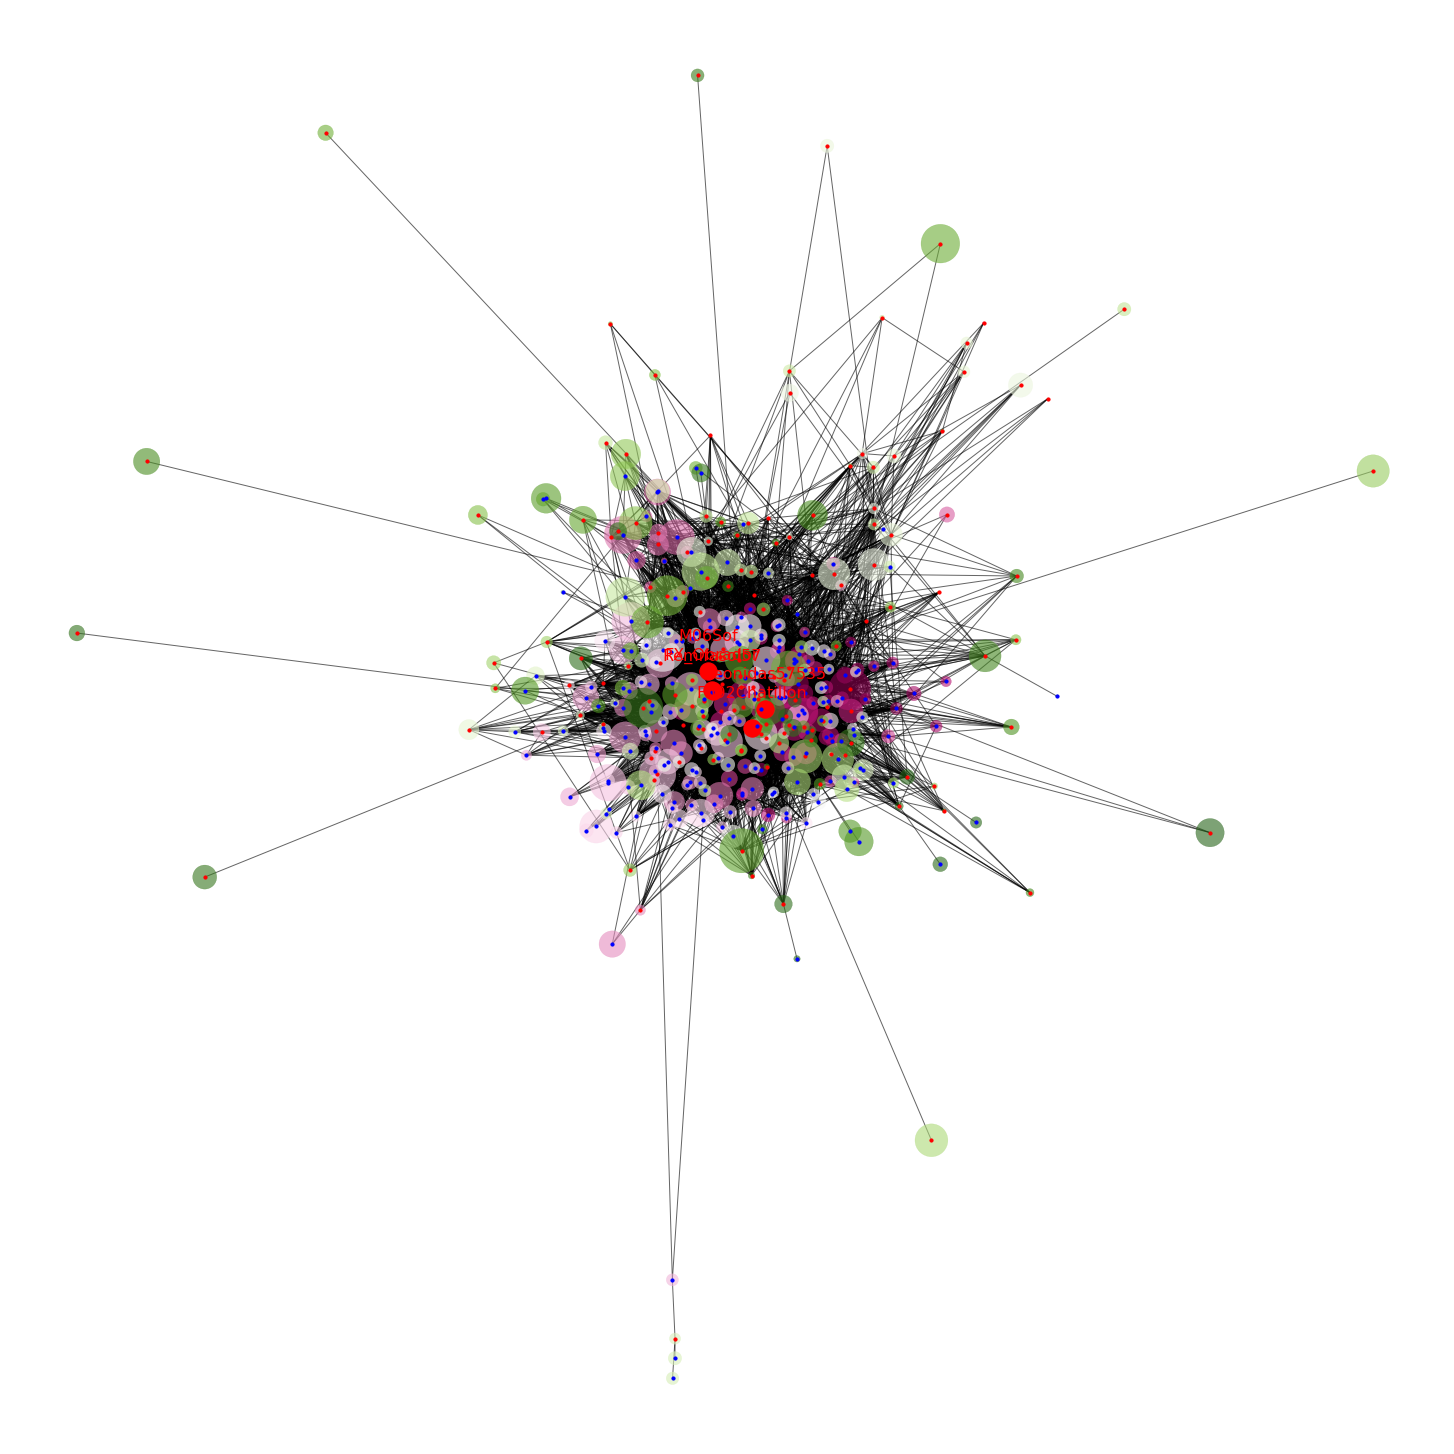

In [40]:
plt.figure(figsize = (20,20))

nx.draw(largest_subgraph, font_weight='bold', pos=pos, node_color=range(number_of_nodes), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=nodes_weights, alpha=0.6, with_labels=False)


nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes, with_labels=True)


labels = {}    
for node in largest_subgraph.nodes():
    if node in central_nodes:
        labels[node] = node
pos_higher = {}
y_off = 0.05 

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(largest_subgraph,pos_higher,labels,font_size=16,font_color='r')


nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=seed_users, node_size=10, node_color='red', with_labels=True)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=important_users, node_size=10, node_color='blue', with_labels=True)

plt.savefig('graphfinal.png')
plt.show()

In [49]:

list(largest_subgraph.nodes(data=True))
list(largest_subgraph.edges(data=True))

[('Predatoutheures', '20Minutes', {'weight': 90}),
 ('Predatoutheures', 'LeHuffPost', {'weight': 41}),
 ('Predatoutheures', 'le_Parisien', {'weight': 62}),
 ('Predatoutheures', 'BFMTV', {'weight': 185}),
 ('Predatoutheures', 'LouisRielFrance', {'weight': 2}),
 ('Predatoutheures', 'CNEWS', {'weight': 7}),
 ('Predatoutheures', 'Le_Figaro', {'weight': 129}),
 ('Predatoutheures', 'franceinfo', {'weight': 43}),
 ('Predatoutheures', 'lemondefr', {'weight': 51}),
 ('Predatoutheures', 'LCI', {'weight': 22}),
 ('Predatoutheures', 'MarianneleMag', {'weight': 24}),
 ('Predatoutheures', 'afpfr', {'weight': 39}),
 ('Predatoutheures', '_Stalker_69_', {'weight': 160}),
 ('Predatoutheures', 'Gjpvernant', {'weight': 1}),
 ('Predatoutheures', 'nadine__morano', {'weight': 19}),
 ('Predatoutheures', 'Europe1', {'weight': 54}),
 ('Predatoutheures', 'DLF_Officiel', {'weight': 1}),
 ('Predatoutheures', 'DanielPilotte2', {'weight': 184}),
 ('Predatoutheures', '__Verlaine__', {'weight': 26}),
 ('Predatoutheure

In [54]:
list(largest_subgraph.nodes(data=True))[0][1]

{'weight': 1759}

In [58]:
data_set = {"nodes": [{"id":node[0], "name":node[0], "val":node[1]['weight']} for node in list(largest_subgraph.nodes(data=True))], 
            "links": [{"source":node[0], "target":node[1], "val":node[2]['weight']} for node in list(largest_subgraph.edges(data=True))]}

with open('interaction_graph.json', 'w') as outfile:
    json.dump(data_set, outfile)